# JPEG Basics

In [1]:
import itertools
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import view_as_blocks
from skimage.color import rgb2gray
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.fftpack import dct, idct

import rle
import huffman
import zigzag

## Compressing

Most of the compression is done during Huffman encoding. To be effective, it is necessary that the coefficients are distributed very unevenly. You can achieve this by applying a discrete cosine transform (DCT).

### Prepare

Take an image and split it to blocks with a size 8x8. These blocks will be used for the application of DCT. Why 8? Some statistics here: 4 is bad, 8 is good enough and 16 is similar to 8.

In [2]:
block_shape = (8, 8)

chelsea = data.chelsea()
chelsea = np.rint(rgb2gray(chelsea) * 255).astype(np.uint8)

height = chelsea.shape[0] // block_shape[0] * block_shape[0]
width = chelsea.shape[1] // block_shape[1] * block_shape[1]

chelsea = chelsea[:height, :width]

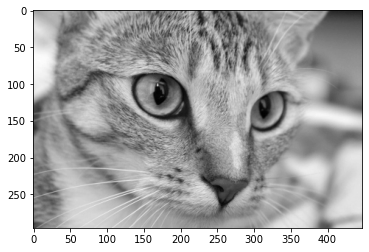

In [3]:
plt.imshow(chelsea, cmap='gray')
plt.show()

In [4]:
def filesize(array):
    kb = 1024
    
    bytes_count = len(bytearray(array))
    return str(bytes_count // kb) + ' kb'

In [5]:
filesize(chelsea)

'129 kb'

### Apply discrete cosine transform and perform quantization

A discrete cosine transform (DCT) expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies. See explanations [here](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/).

From DCT we receive some coefficients. Most important are in upper left corner.

We use more bits to store important coefficients than to store unimportant ones. This is quantization.

In [6]:
def dct2d(array):
    return dct(dct(array, norm='ortho', axis=-1), norm='ortho', axis=-2)

def idct2d(array):
    return idct(idct(array, norm='ortho', axis=-1), norm='ortho', axis=-2)

Common JPEG quantization matrix. Just divide DCT coefficients to matrix values.

In [7]:
quantization_table = np.array([
    [16,  11,  10,  16,  24,   40,   51,   61 ],
    [12,  12,  14,  19,  26,   58,   60,   55 ],
    [14,  13,  16,  24,  40,   57,   69,   56 ],
    [14,  17,  22,  29,  51,   87,   80,   62 ],
    [18,  22,  37,  56,  68,   109,  103,  77 ],
    [24,  35,  55,  64,  81,   104,  113,  92 ],
    [49,  64,  78,  87,  103,  121,  120,  101],
    [72,  92,  95,  98,  112,  100,  103,  99 ]])

In [8]:
def quantize_block(block):
    coefs = dct2d(block) / quantization_table
    
    return np.rint(coefs + 127).clip(0, 255).astype(np.uint8)

In [9]:
def quantize(image):
    view = view_as_blocks(image, block_shape)
    coefs = np.zeros_like(view, dtype=np.uint8)

    for row in range(view.shape[0]):
        for col in range(view.shape[1]):
            coefs[row][col] = quantize_block(view[row][col])
    
    return coefs

Take some block of size 8x8

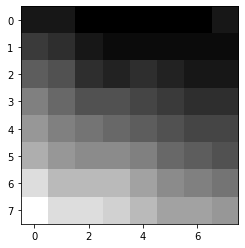

In [10]:
plt.imshow(chelsea[0 : 8, 0 : 8], cmap='gray')
plt.show()

In [11]:
coefs = quantize(chelsea.copy())

This is quantized dct coefficients.

In [12]:
coefs[0][0].astype(np.int8) - 127

array([[65,  1,  0,  0,  0,  0,  0,  0],
       [-4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]], dtype=int8)

Most of them are zeros. Nonzero values are in upper left corner.

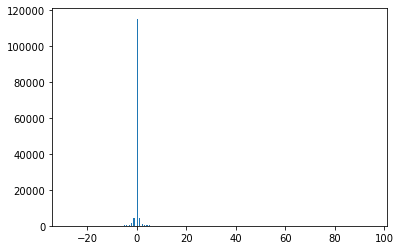

In [13]:
plt.hist(coefs.flatten().astype(np.int8) - 127, bins=255)
plt.show()

### Prepare to huffman coding: zigzag scan and run-length encoding

We use a zigzag scan to place all zeros in a row and then apply run-length encoding (RLE). If we don't do this, huffman coding will perform worse.

In [14]:
coefs_zigzaged = zigzag.scan(coefs.reshape(-1, 8, 8))

In [15]:
coefs_zigzaged_rled = rle.code(coefs_zigzaged)

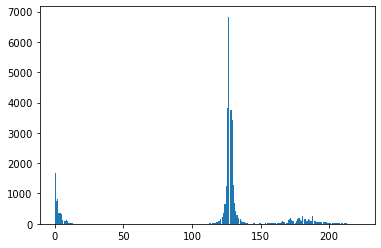

In [16]:
plt.hist(coefs_zigzaged_rled, bins=255)
plt.show()

### Apply huffman coding

In [17]:
codes = huffman.make_codes(Counter(coefs_zigzaged_rled))

In [18]:
length, coded = huffman.code(coefs_zigzaged_rled, codes)

We made the image seven times smaller!

In [19]:
filesize(coded), len(bytearray(chelsea)) / len(bytearray(coded))

('18 kb', 6.942463745353646)

## Decompressing

### Decode using huffman, rle and zigzag algroithms

In [20]:
coefs_zigzaged_rled = huffman.decode(coded, codes, length)

In [21]:
coefs_zigzaged = rle.decode(coefs_zigzaged_rled)

In [22]:
coefs = zigzag.inverse(np.array(coefs_zigzaged)).reshape(height // block_shape[0], width // block_shape[1], *block_shape)

### Dequantize coefficients and apply inverse discrete cosine transform

In [23]:
def restore_block(block):
    coefs = block.astype(np.int8) - 127

    return np.rint(idct2d(coefs * quantization_table)).clip(0, 255).astype(np.uint8)

In [24]:
def restore(coefs):
    image = np.zeros((height, width), dtype=np.uint8)
    view = view_as_blocks(image, block_shape)

    for row in range(view.shape[0]):
        for col in range(view.shape[1]):
            view[row][col] = restore_block(coefs[row][col])
    
    return image

In [25]:
decompressed = restore(coefs)

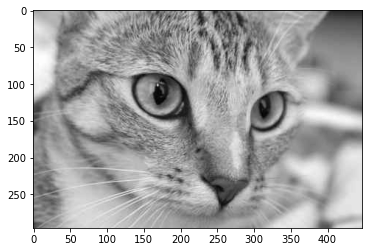

In [26]:
plt.imshow(decompressed, cmap='gray')
plt.show()

### Let's see how well we were able to save the image

In [27]:
psnr(chelsea, decompressed), ssim(chelsea, decompressed)

(35.23077157288648, 0.9371037802503691)